# Resume Parsing

## 1. Load data

The provided code imports the pandas library with the alias `pd` and the numpy library with the alias `np` in Python. This allows for the usage of pandas and numpy functions and classes in the code. Additionally, comments have been added to explain each import statement.

In [1]:
import pandas as pd
import numpy as np

The provided code reads a CSV file named "resume.csv" using the pandas library and assigns the resulting DataFrame to the variable `df_resume`.


In [2]:

df_resume = pd.read_csv("data/resume.csv")

In [3]:
df_resume.Category.unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [4]:
df_resume.shape

(2484, 4)

The provided code performs several operations on the DataFrame `df_resume` using pandas and numpy libraries.

In [5]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]
df_resume.shape

(1000, 4)

## 2. Load skill data

If we define patterns for all the skill, we gonna be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

The provided code loads the pre-trained English model `en_core_web_md` using spaCy, then adds an entity ruler to the pipeline by loading rules from a file named 'skills.jsonl'. Finally, it retrieves the names of the components in the spaCy pipeline.

In [6]:
import spacy

In [7]:
!python3 -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 13.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [8]:
nlp = spacy.load('en_core_web_md') # Load pre-trained English model
skill_path = 'data/skills.jsonl' 

In [9]:
ruler = nlp.add_pipe("entity_ruler") # Add an entity ruler to the spaCy pipeline
ruler.from_disk(skill_path) # Load rules from the specified file
nlp.pipe_names  # Retrieve names of components in the spaCy pipeline

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [10]:
doc = nlp("shafi loves deep learning") # Process the text using the spaCy NLP pipeline
doc.ents   # Extract entities from the processed document

(shafi, deep learning)

## 3. Let's try to extract skills from this resume.csv

The provided code defines a function named `preprocessing` that cleans text data by removing stop words, punctuation, symbols, and spaces using spaCy. It then lemmatizes the remaining tokens and returns a cleaned sentence.

In [11]:
#clean our data
from spacy.lang.en.stop_words import STOP_WORDS

def preprocessing(sentence):
    stopwords    = list(STOP_WORDS)
    doc          = nlp(sentence)
    clean_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SYM' and \
            token.pos_ != 'SPACE':
                clean_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(clean_tokens)

In [12]:
random_resume = df_resume.Resume_str.iloc[1]
random_resume[:300]

'         HISTORY TEACHER       Professional Summary    To be employed as an Administrative Assistant or similar role where my\ninterpersonal communication, time management, problem resolution, and organizational\nskills will benefit the company. Technically-adept  [Job Title]  with advanced knowledge '

In [13]:
preprocessing(random_resume[:300])

'history teacher professional summary to employ administrative assistant similar role interpersonal communication time management problem resolution organizational skill benefit company technically adept job title advanced knowledge'

preprocessing resume data stored in a DataFrame `df_resume` by applying the `preprocessing` function to each resume string. It then stores the cleaned text in a new column named 'Clean_resume'.


In [14]:
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [15]:
df_resume.head()


,ID,Resume_str,Resume_html,Category,Clean_resume
2236,16300459,FINANCIAL EDITOR ASSISTANT Summ...,"<div class=""fontsize fontface vmargins hmargin...",BANKING,financial editor assistant summary strong moti...
414,86597425,HISTORY TEACHER Professional Su...,"<div class=""fontsize fontface vmargins hmargin...",TEACHER,history teacher professional summary to employ...
390,17311685,KINDERGARTEN TEACHER Summary ...,"<div class=""fontsize fontface vmargins hmargin...",TEACHER,kindergarten teacher summary dedicated educato...
1125,22259768,CONSULTANT Profile Around 5 ...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT,consultant profile around 5 year experience ga...
604,26278597,BUSINESS DEVELOPMENT MANAGER Su...,"<div class=""fontsize fontface vmargins hmargin...",BUSINESS-DEVELOPMENT,business development manager summary an experi...


## 4.1 Let's really extract skills!!

The provided code defines two functions: `get_skills` and `unique_skills`, and then applies these functions to extract and process skills from resume data stored in a DataFrame `df_resume`.


In [16]:
def get_skills(text):
    """
    Extract skills from text using spaCy NLP pipeline.
    
    Args:
    text (str): Input text to extract skills from.
    
    Returns:
    list: List of skills extracted from the input text.
    """
    
    doc = nlp(text)
    
    skills = []
    
    for ent in doc.ents:
        if ent.label_ == 'SKILL':
            skills.append(ent.text)
            
    return skills

def unique_skills(x):
    """
    Return unique skills from a list of skills.
    
    Args:
    x (list): List of skills.
    
    Returns:
    list: List containing unique skills.
    """
    return list(set(x))

In [36]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills) # Apply the get_skills function to each resume text and store the extracted skills in a new column
df_resume['Skills'] = df_resume.Skills.apply(unique_skills) # Apply the unique_skills function to each list of skills to ensure uniqueness

## 4.2 Extract Work Experience [additional features or improvements inspired by spaCy’s capabilities ]

In [37]:
from spacy.matcher import Matcher
from spacy.tokens import Span

In [38]:
# Initialize the Matcher with the shared vocabulary
matcher = Matcher(nlp.vocab)

# Define patterns to identify work experience
patterns = [
    [{"POS": "PROPN", "OP": "+"}, {"LOWER": "at"}, {"POS": "PROPN", "OP": "+"}],
    [{"POS": "NOUN", "OP": "+"}, {"POS": "ADP"}, {"POS": "PROPN", "OP": "+"}],
    [{"POS": "VERB"}, {"POS": "NOUN", "OP": "+"}, {"LOWER": "at"}, {"POS": "PROPN", "OP": "+"}],
]

matcher.add("WORK_EXPERIENCE", patterns)

def get_work_experience(text):
    # Process the text with spaCy
    doc = nlp(text)

    # Find matches in the doc
    matches = matcher(doc)

    # Collect spans from matches
    spans = []
    for _, start, end in matches:
        span = doc[start:end]  # Extract the matched span
        spans.append(span.text)  # Add the text of the span to the results

    return spans

In [39]:
# Apply the function to each row in 'Clean_resume' column
df_resume['Work_Experience'] = df_resume['Clean_resume'].apply(get_work_experience)


In [40]:
df_resume[df_resume['Work_Experience'].notnull() & (df_resume['Work_Experience'].str.len() > 0)].head(5)


,ID,Resume_str,Resume_html,Category,Clean_resume,Skills,Work_Experience,Contact_Info,Certifications
814,24251588,CERTIFIED FITNESS TRAINER P...,"<div class=""fontsize fontface vmargins hmargin...",FITNESS,certified fitness trainer professional summary...,"[marketing, collaboration, material, material ...","[walk in ti, lead walk in ti, sale lead walk i...",[],"[certified, certified fitness, certified fitne..."
452,13967854,VICTIM ADVOCATE Professional Su...,"<div class=""fontsize fontface vmargins hmargin...",ADVOCATE,victim advocate professional summary social wo...,"[security, support, mode, database]","[bridges out poverty, bridges out poverty knox...",[],"[certification, certification process, certifi..."
2008,39566718,OWNER/PROJECT MANAGER Executive...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,owner project manager executive summary experi...,"[project management, documentation, schedule, ...","[solution gsm umts, solution gsm umts dnb, sol...",[],"[certified, certified ms, certified ms word, c..."
2211,17823436,BUSINESS ANALYST SR. TECHNICAL BUSINESS...,"<div class=""fontsize fontface vmargins hmargin...",BANKING,business analyst sr technical business analyst...,"[documentation, oracle, payments, engineering,...",[team like ubps],[],"[certificate, certificate download, certificat..."
931,23631188,ACCOUNTS PAYABLE AP - (CREDITORS) SUP...,"<div class=""fontsize fontface vmargins hmargin...",AGRICULTURE,account payable ap creditors supervisor summar...,"[documentation, schedule, accounting, utilitie...","[setup •develop implement, information setup •...",[],"[certificate, certificate practical, certifica..."


## 4.3 Extract Contact Info [additional features or improvements inspired by spaCy’s capabilities ]

In [41]:
# Assuming nlp and matcher have already been initialized
contact_info_patterns = [
    [{"LIKE_EMAIL": True}],  # Simple pattern for email addresses
    # You can add more patterns here for phone numbers, etc.
]

matcher.add("CONTACT_INFO", contact_info_patterns)

In [42]:
def get_contact_info(text):
    doc = nlp(text)
    matches = matcher(doc)
    contact_info = []

    for match_id, start, end in matches:
        span = doc[start:end]
        if nlp.vocab.strings[match_id] == "CONTACT_INFO":
            contact_info.append(span.text)

    return contact_info


In [43]:
df_resume['Contact_Info'] = df_resume['Clean_resume'].apply(get_contact_info)

In [44]:
df_resume[df_resume['Contact_Info'].notnull() & (df_resume['Contact_Info'].str.len() > 0)].head(5)

,ID,Resume_str,Resume_html,Category,Clean_resume,Skills,Work_Experience,Contact_Info,Certifications
1221,26919036,CONSULTANT ACCOUNT Summary T...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT,consultant account summary this letter express...,"[project management, interaction, collaboratio...",[],[novella.walton@verizonwireless.com],[]
2283,15265464,INTERVENTION SPECIALIST TEACHER OF MA...,"<div class=""fontsize fontface vmargins hmargin...",ARTS,intervention specialist teacher of math and la...,"[devise, collaboration, monitoring, schedule, ...",[],[nic_harrison@aol.com],"[certification, certification elementary, cert..."
1819,19545827,ACCOUNTANT Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",ACCOUNTANT,accountant highlights -soft skill public speak...,"[project management, schedule, accounting, win...",[],[dkterry40@sbcglobal.net],[]
386,23398843,TEACHER Facebook: Lamaest...,"<div class=""fontsize fontface vmargins hmargin...",TEACHER,teacher facebook lamaestram4kidscare@yahoo.com...,"[project management, play, tracking system, mo...","[education(aas of ece, childhood education(aas...","[lamaestram4kidscare@yahoo.com, mariela28perez...","[certification, certification proficient, cert..."
2410,28383893,SENIOR WARRANT OFFICER ADVISOR ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION,senior warrant officer advisor summary a dedic...,"[project management, specification, aeronautic...",[],"[joseph.j.hodgson.mil@mail.mil, daniel.j.odonn...","[certified, certified instructional, certified..."


## 4.4. Extract Certification [additional features or improvements inspired by spaCy’s capabilities ]

In [45]:
certification_patterns = [
    [{"LOWER": "certified"}, {"IS_ALPHA": True, "OP": "*"}],
    [{"LOWER": "certificate"}, {"IS_ALPHA": True, "OP": "*"}],
    [{"LOWER": "certification"}, {"IS_ALPHA": True, "OP": "*"}],
    # Add more patterns as necessary
]

matcher.add("CERTIFICATION", certification_patterns)

In [46]:
def get_certification(text):
    doc = nlp(text)
    matches = matcher(doc)
    certifications = []

    for match_id, start, end in matches:
        span = doc[start:end]
        if nlp.vocab.strings[match_id] == "CERTIFICATION":
            certifications.append(span.text)

    return certifications

In [47]:
df_resume['Certifications'] = df_resume['Clean_resume'].apply(get_certification)


In [48]:
df_resume[df_resume['Certifications'].notnull() & (df_resume['Certifications'].str.len() > 0)].head(5)

,ID,Resume_str,Resume_html,Category,Clean_resume,Skills,Work_Experience,Contact_Info,Certifications
414,86597425,HISTORY TEACHER Professional Su...,"<div class=""fontsize fontface vmargins hmargin...",TEACHER,history teacher professional summary to employ...,"[business, collaboration, material, accounting...",[],[],"[certification, certification skills, certific..."
1192,16964217,CONSULTANT Professional Sum...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT,consultant professional summary certified nurs...,"[documentation, certificate, support, schedule]",[],[],"[certified, certified nursing, certified nursi..."
1998,12654876,SENIOR FACILITIES AND CONSTRUCTION PR...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,senior facility and construction project manag...,"[security, design, support, business]",[],[],"[certified, certified project, certified proje..."
2272,20149476,VISUAL ARTS TEACHER Summary ...,"<div class=""fontsize fontface vmargins hmargin...",ARTS,visual arts teacher summary art education prof...,"[medium, material, windows, certificate, desig...",[],[],[certificate]
1088,36970996,SALES CONSULTANT Professional S...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale consultant professional summary customer ...,"[business, schedule, advertising, database, de...",[],[],"[certification, certification like, certificat..."


## 5. Visualization

Which skills is most important in INFORMATION TECHNOLOGY?

The provided code filters resume data based on a specified category ('INFORMATION-TECHNOLOGY') and creates a new DataFrame `df_resume_it` containing only the resumes belonging to that category. Additionally, the code retrieves the shape of the filtered DataFrame.

In [49]:
category = 'INFORMATION-TECHNOLOGY'
# category = 'ACCOUNTANT'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(47, 9)

In [50]:
all_skills = np.concatenate(df_resume_it.Skills.values)

In [51]:
from collections import Counter, OrderedDict

counting = Counter(all_skills)
counting = OrderedDict(counting.most_common(10))

In [52]:
counting

OrderedDict([('support', 44),
             ('software', 38),
             ('security', 34),
             ('design', 33),
             ('business', 30),
             ('windows', 30),
             ('database', 29),
             ('server', 25),
             ('project management', 21),
             ('documentation', 19)])

<BarContainer object of 10 artists>

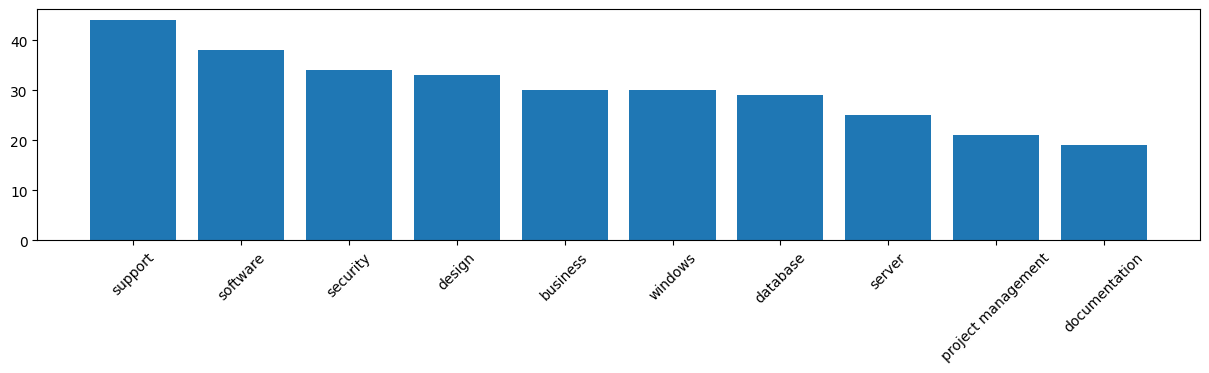

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation=45)

plt.bar(counting.keys(), counting.values())

## 6. Name Entity Recognition

### 6.1. The visualization highlights entities labeled as 'SKILL' with a specific color gradient. 

The provided code visualizes named entities in a resume text from the DataFrame `df_resume_it` using spaCy's `displacy` module. The visualization highlights entities labeled as 'SKILL' with a specific color gradient. 

In [54]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[32]

In [55]:
doc = nlp(text)

In [56]:
# Assuming 'doc' is your processed document
for ent in doc.ents:
    print(ent.text, ent.label_)


03/2009 DATE
21674 CARDINAL
security SKILL
wireless SKILL
18640 DATE
10/30/12 27481 CARDINAL
03/20/12 36542 CARDINAL
windows SKILL
7 CARDINAL
30688 MONEY
security SKILL
02/03/12 CARDINAL
01/23/12 34601 CARDINAL
09/27/11 31699 CARDINAL
09/26/11 31856 CARDINAL
windows SKILL
server SKILL
2008 DATE
04/01/11 CARDINAL
28902 MONEY
security SKILL
windows SKILL
2003 DATE
01/31/11 28801 CARDINAL
database SKILL
encryption SKILL
04/09/10 CARDINAL
23796 MONEY
21797 CARDINAL
voice over ip SKILL
21674 CARDINAL
security SKILL
wireless SKILL
17090 MONEY
wireless SKILL
17623 MONEY
monitoring SKILL
21597 CARDINAL
04/25/08 18287 CARDINAL
itil problem change ORG
18054 DATE
karta GPE
18064 CARDINAL
karta GPE
security SKILL
13085 CARDINAL
08/03/06 14115 CARDINAL
security SKILL
security SKILL
07/31/06 14780 MONEY
wireless SKILL
security SKILL
15248 CARDINAL
windows SKILL
server SKILL
2003 DATE
04/07/06 17633 CARDINAL
03/24/06 18035 MONEY
03/23/06 18041 CARDINAL
karta GPE
03/22/06 18034 CARDINAL
karta GPE
03/1

In [57]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style='ent', options=options)

### 6.2. The visualization highlights entities labeled as 
- WORK_EXPERIENCE
- CERTIFICATION
- CONTACT_INFO
 with a specific color gradient. 
 
 [ Additional features or improvements inspired by spaCy’s capabilities ]

In [70]:
from spacy.tokens import Span
from spacy.matcher import Matcher
from spacy import displacy
from IPython.display import display, HTML

# Load spaCy model
# nlp = spacy.load('en_core_web_md')

# Initialize Matcher with the vocab
matcher = Matcher(nlp.vocab)

# Define patterns for each entity type
patterns = {
    "WORK_EXPERIENCE": [
        [{"POS": "PROPN", "OP": "+"}, {"LOWER": "at"}, {"POS": "PROPN", "OP": "+"}],
        [{"POS": "NOUN", "OP": "+"}, {"POS": "ADP"}, {"POS": "PROPN", "OP": "+"}],
        [{"POS": "VERB"}, {"POS": "NOUN", "OP": "+"}, {"LOWER": "at"}, {"POS": "PROPN", "OP": "+"}],
    ],
    "CERTIFICATION": [
        [{"LOWER": "certified"}, {"IS_ALPHA": True, "OP": "*"}],
        [{"LOWER": "certificate"}, {"IS_ALPHA": True, "OP": "*"}],
        [{"LOWER": "certification"}, {"IS_ALPHA": True, "OP": "*"}],
    ],
    "CONTACT_INFO": [
        [{"LIKE_EMAIL": True}],
        # Add patterns for phone numbers or other contact info as needed
    ]
}

# Add patterns to matcher
for label, pattern in patterns.items():
    matcher.add(label, pattern)


def visualize_entities(text):
    doc = nlp(text)
    matches = matcher(doc)
    
    # Create a list to hold the new entities
    new_ents = []
    
    # Iterate through the matches and create Span objects for new entities
    for match_id, start, end in matches:
        # Ensure no overlaps with new entities
        if not any(start <= ent.start < end or start < ent.end <= end for ent in new_ents):
            new_ents.append(Span(doc, start, end, label=nlp.vocab.strings[match_id]))
    
    # Temporarily set doc.ents to include both new and original entities, avoiding overlaps
    original_ents = list(doc.ents)  # Convert original entities to a list
    combined_ents = original_ents + new_ents
    non_overlapping_ents = []
    covered_chars = set()
    for ent in combined_ents:
        if not any(i in covered_chars for i in range(ent.start_char, ent.end_char)):
            non_overlapping_ents.append(ent)
            covered_chars.update(range(ent.start_char, ent.end_char))
    doc.ents = non_overlapping_ents

    # Define custom colors for displaying entities, including "SKILL"
    colors = {
        "WORK_EXPERIENCE": "linear-gradient(90deg, #9cd2fc, #9caffc)",
        "CERTIFICATION": "linear-gradient(90deg, #9cfca2, #9cfcaf)",
        "CONTACT_INFO": "linear-gradient(90deg, #fc9c9c, #fcaf9c)",
        "SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"  # Add custom color for "SKILL"
    }
    options = {"colors": colors}

    # Render with displacy and display in Jupyter Notebook
    html = displacy.render(doc, style='ent', options=options, minify=True, page=True)
    display(HTML(html))

    # Restore original entities to not affect further processing
    doc.ents = original_ents


# Example usage
text_example = "John Doe, certified Python developer, worked at Google from 2010 to 2015. Contact: john.doe@example.com."
visualize_entities(text_example)

<IPython.core.display.HTML object>

#### Visualization of Work_Experience entities

In [71]:
# Filter DataFrame for non-empty 'Work_Experience'
df_with_work_experience = df_resume[df_resume['Work_Experience'].map(len) > 0]

# Visualize entities for the first resume with Work_Experience info
if not df_with_work_experience.empty:
    text_example = df_with_work_experience['Clean_resume'].iloc[0]
    visualize_entities(text_example)
else:
    print("No entries with Work_Experience information found.")


<IPython.core.display.HTML object>

#### Visualization of Certifications entities

In [72]:
# Filter DataFrame for non-empty 'Certifications'
df_with_certifications = df_resume[df_resume['Certifications'].map(len) > 0]

# Visualize certifications for the first resume with certification info
if not df_with_certifications.empty:
    text_example = df_with_certifications['Clean_resume'].iloc[0]
    visualize_entities(text_example)
else:
    print("No entries with certification information found.")

<IPython.core.display.HTML object>

#### Visualization of Contact_Info entities

In [73]:
# Filter DataFrame for non-empty 'Contact_Info'
df_with_Contact_Info = df_resume[df_resume['Contact_Info'].map(len) > 0]

# Visualize Contact_Info for the first resume with Contact_Info info
if not df_with_Contact_Info.empty:
    text_example = df_with_Contact_Info['Clean_resume'].iloc[0]
    visualize_entities(text_example)
else:
    print("No entries with Contact_Info information found.")

<IPython.core.display.HTML object>

#### Visualization all Work_Experience, Certifications, Contact_Info

In [74]:
filtered_df = df_resume[(df_resume['Work_Experience'].map(len) > 0) & 
                        (df_resume['Certifications'].map(len) > 0) & 
                        (df_resume['Contact_Info'].map(len) > 0)]

# Get iloc indexes if needed
iloc_indexes = filtered_df.index.tolist()
# Example: Visualizing entities for the first 3 selected resumes
for index in iloc_indexes[:3]:  # Adjust as needed to manage output
    text_example = df_resume.loc[index, 'Clean_resume']
    print(f"Visualizing entities for resume at index {index}:")
    visualize_entities(text_example)
    print("\n---\n")  # Separator for readability


Visualizing entities for resume at index 386:


<IPython.core.display.HTML object>


---



## 7. Represent the Resume Content as a Structure Table

In [90]:
def extract_all_information(text):
    doc = nlp(text)
    
    # Initialize a dictionary to hold extracted information
    extracted_info = {
        "Person Name": [],
        "Skill": [],
        "Work Experience": [],
        "Certification": [],
        "Contact Info": []
    }
    
    # Extract entities using doc.ents for Person Name and pre-defined matchers for others
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            extracted_info["Person Name"].append(ent.text)
        elif ent.label_ == "SKILL":
            extracted_info["Skill"].append(ent.text)
        # Add conditions for other entity types if they're part of doc.ents
    
    # Extract entities using matcher for custom-defined entities
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]  # The matched span
        label = nlp.vocab.strings[match_id]  # Get string representation
        if label in ["WORK_EXPERIENCE", "CERTIFICATION", "CONTACT_INFO"]:
            # Map spaCy labels to dictionary keys
            key = label.title().replace("_", " ")
            extracted_info[key].append(span.text)
    
    # Deduplicate lists
    for key in extracted_info.keys():
        extracted_info[key] = list(set(extracted_info[key]))
    
    return extracted_info

In [95]:
# Apply the function to the 'Clean_resume' text of the first row
single_resume_info = extract_all_information(df_resume['Clean_resume'].iloc[32])

# Display the extracted information
df_single_resume_info = pd.DataFrame(list(single_resume_info.items()), columns=['Entity Type', 'Extracted Information'])

# Display the DataFrame as a table
display(df_single_resume_info)

,Entity Type,Extracted Information
0,Person Name,"[burke mentor, caterer provisioner sous chef, ..."
1,Skill,"[schedule, chef, business administration, busi..."
2,Work Experience,[]
3,Certification,"[certified foodmanager servsafe, certified, ce..."
4,Contact Info,[]


## 7. Let's load the PDF - add some realism

In [98]:
from PyPDF2 import PdfReader

reader = PdfReader("data/resume-shafi.pdf")
page = reader.pages[0]
text = page.extract_text()

In [99]:
text = preprocessing(text)

In [100]:
visualize_entities(text)

<IPython.core.display.HTML object>

In [101]:
single_resume_info = extract_all_information(text)
# Display the extracted information
df_single_resume_info = pd.DataFrame(list(single_resume_info.items()), columns=['Entity Type', 'Extracted Information'])

# Display the DataFrame as a table
display(df_single_resume_info)

,Entity Type,Extracted Information
0,Person Name,"[mrcnn llm framework, debiase, shafi ud]"
1,Skill,"[project management, ml, mongodb, semantics, a..."
2,Work Experience,[]
3,Certification,[]
4,Contact Info,[shafi.cse.brur@gmail.com]
